<a href="https://colab.research.google.com/github/RSL23RSL/Atividade-Avaliativa-Final/blob/main/exercicio_Modelo_difusaoRenato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib numpy tqdm

In [15]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [16]:

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


In [4]:
soma = 5 + 10
print(f"hello {soma}")

hello 15


In [18]:
T = 200
beta_start = 1e-4
beta_end = 0.02

beta = torch.linspace(beta_start, beta_end, T).to(device)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)


In [5]:
def time_embedding(t, dim=64):
    half = dim // 2
    emb = math.log(10000) / (half - 1)
    emb = torch.exp(torch.arange(half, device=device) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
    return emb


In [19]:
class MiniUNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(time_embedding(t, 64)).view(-1, 64, 1, 1)
        h = F.relu(self.conv1(x))
        h = h + t_emb[:, :32]
        h = F.relu(self.conv2(h))
        return self.conv3(h)


In [7]:
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    a_bar = alpha_bar[t].view(-1, 1, 1, 1)
    xt = torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise
    return xt, noise



In [20]:
model = MiniUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5

for epoch in range(epochs):
    for x, _ in loader:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device)

        xt, noise = forward_diffusion(x, t)
        noise_pred = model(xt, t)

        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")


Epoch 1/5 | Loss: 0.1034
Epoch 2/5 | Loss: 0.0924
Epoch 3/5 | Loss: 0.0940
Epoch 4/5 | Loss: 0.0929
Epoch 5/5 | Loss: 0.0785


In [21]:
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        eps = model(x, t_batch)
        a = alpha[t]
        a_bar = alpha_bar[t]
        x = (x - (1 - a) / torch.sqrt(1 - a_bar) * eps) / torch.sqrt(a)
        if t > 0:
            x += torch.sqrt(beta[t]) * torch.randn_like(x)
    return x


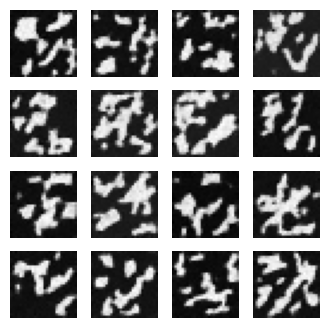

In [22]:
samples = sample(model, n=16).cpu()

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


In [24]:
checkpoint = {
    "model_state": model.state_dict(),
    "T": T,
    "beta_start": beta_start,
    "beta_end": beta_end
}

torch.save(checkpoint, "mini_difusao_mnist.pth")
print("Checkpoint salvo: mini_difusao_mnist.pth")


Checkpoint salvo: mini_difusao_mnist.pth


In [25]:
from google.colab import files
files.download("mini_difusao_mnist.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>